In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/ssd_keras'

/content/drive/My Drive/ssd_keras


In [0]:
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size
n_classes = 2 # Number of positive classes

In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from pyimagesearch.smallervggnet import SmallerVGGNet
from imutils import paths
import argparse
import random
import pickle
import os
# import the necessary packages
from keras.preprocessing.image import img_to_array
#import argparse
import imutils

In [0]:
# pre-process the image for classification
def preprocessing_top_clothes(image):
  image = cv2.resize(image, (96, 96))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  return image

In [9]:
# Load model person
# TODO: Set the path to the `.h5` file of the model to be loaded.
# Load top clothes and it's labels
top_clothes_model = load_model("/content/drive/My Drive/Train_clothes/clothes.h5")
mlb = pickle.loads(open("/content/drive/My Drive/Train_clothes/labelbin.pickle", "rb").read())

# load model person and upper body
model_person_path = '/content/drive/My Drive/ssd_keras/epoch 1-99 person vgg16_7-layer/ssd7_epoch-99_loss-1.9277_val_loss-1.9274.h5'
model_upper_path = '/content/drive/My Drive/ssd_keras/epoch 1-20 upper vgg16_7-layer/ssd7_epoch-18_loss-1.6272_val_loss-1.5319.h5'
# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

#K.clear_session() # Clear previous models from memory.

person_model = load_model(model_person_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
upper_model = load_model(model_upper_path, custom_objects={'AnchorBoxes': AnchorBoxes,'compute_loss': ssd_loss.compute_loss})

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
top_clothes_model.summary()

In [0]:
person_model.summary()

In [0]:
upper_model.summary()

In [0]:
def resize_image(img, input_size):
  img_height, img_width = input_size
  img = cv2.resize(img, (img_width, img_height))
  img = img.reshape(1,img_height,img_width,3)
  return img

In [0]:
def get_object_pos(img, input_size, model):
  y_pred = model.predict(img)
  y_pred_decoded = decode_detections(y_pred,
                                     confidence_thresh=0.5,
                                     iou_threshold=0.45,
                                     top_k=200,
                                     normalize_coords=True,
                                     img_height=input_size[0],
                                     img_width=input_size[1])

  np.set_printoptions(precision=2, suppress=True, linewidth=90)
  return y_pred_decoded[0]
#   print("Predicted boxes:\n")
#   print('   class   conf xmin   ymin   xmax   ymax')
#   print(y_pred_decoded[0])



def draw_box(img, model):
  #plt.figure(figsize=(15,7))
  #plt.imshow(img[0])
  input_size = np.array(list(map(lambda x: int(x), model.input.shape[1:3])))
  
  #colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
  
  #classes = ['background', 'object'] # Just so we can print class names onto the image instead of IDs

  # Ảnh lấy từ mạng ko có ground truth như validation data
  # Draw the predicted boxes in blue
  object_pos = get_object_pos(img, input_size, model)
  object_split = []
  sub_pos_total = []
  
  #current_axis = plt.gca()

  for box in object_pos:
      xmin = box[-4]
      ymin = box[-3]
      xmax = box[-2]
      ymax = box[-1]
      
      if object_split != False:
        sub_pos = list(map(lambda x: int(x), [xmin, ymin, xmax, ymax]))
        img_sub = img[0][sub_pos[1]:sub_pos[3], sub_pos[0]:sub_pos[2]]
        object_split.append(img_sub)
        sub_pos_total.append(np.array(sub_pos))

      #color = colors[int(box[0])]
      #label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
      #current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
      #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
  return object_split, sub_pos_total

(1712, 2500, 3)
(1, 300, 300, 3)


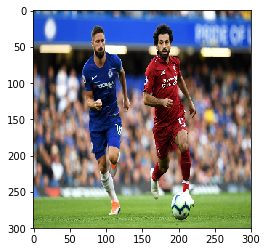

In [32]:
from PIL import Image
import requests
from io import BytesIO

input_size_person = np.array(list(map(lambda x: int(x), person_model.input.shape[1:3])))
input_size_upper = np.array(list(map(lambda x: int(x), upper_model.input.shape[1:3])))

#response = requests.get('https://c8.alamy.com/comp/T9457M/sisterhood-concept-happy-children-play-together-having-sister-is-always-fun-adorable-sisters-smiling-faces-best-friends-forever-happy-childhood-girls-sisters-having-fun-together-family-love-T9457M.jpg')
#response = requests.get('https://vcdn-english.vnecdn.net/2018/12/14/Park-1544760471-4064-1544762058_680x0.jpg')
#response = requests.get('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/fruche-comp-1541100457.jpg?crop=1.00xw:1.00xh;0,0&resize=480:*')
#response = requests.get('https://kenh14cdn.com/2019/4/6/q-1554564599640382402064.jpg')
response = requests.get('https://static.standard.co.uk/s3fs-public/thumbnails/image/2018/09/29/18/cheliv290918g.jpg')
img = Image.open(BytesIO(response.content))

img = np.array(img)
print(img.shape)
img = resize_image(img, input_size_person)
print(img.shape)
plt.imshow(img[0])

number person detected: 2
red: coat
blue: coat


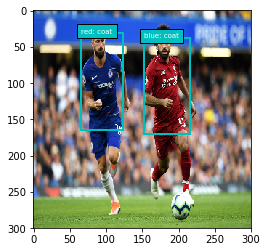

<Figure size 1440x720 with 0 Axes>

In [34]:
# bắt đối tượng người trong ảnh
persons, person_pos = draw_box(img, person_model)
print('number person detected: %s'%len(person_pos))
_, axes = plt.subplots(1)
plt.figure(figsize=(20,10))
axes.imshow(img[0])

# với mỗi người trong ảnh bắt đối tượng áo
for p, p_pos in zip(persons, person_pos):
  if 0 in p.shape: # cannot resize, skip it
    continue
  p_resize = resize_image(p, input_size_upper)
  
  top_clothes, upper_pos_total = draw_box(p_resize, upper_model)
  # convert scale from model upper to model person
  for top_clt, upper_pos in zip(top_clothes, upper_pos_total):
    scale = [p_pos[3] - p_pos[1], p_pos[2] - p_pos[0]]/np.array(input_size_upper)
    x_min, x_max = np.array([upper_pos[0], upper_pos[2]])*scale[1]
    y_min, y_max = np.array([upper_pos[1], upper_pos[3]])*scale[0]
    anchor = np.array([upper_pos[0], upper_pos[1]])*scale[1]
    delta = [x_max-x_min, y_max-y_min]

    x_min_new =  p_pos[0]+anchor[0]
    y_min_new = p_pos[1]+anchor[1]
    upper_pos_new = list(map(lambda x: int(x), [x_min_new, y_min_new, x_min_new + delta[0], y_min_new + delta[1]]))
    
    # classifying clothes
    if 0 in top_clt.shape: # cannot resize, skip it
      continue
    top_clt_pre = preprocessing_top_clothes(top_clt)
    
    proba = top_clothes_model.predict(top_clt_pre)[0]
    idxs = np.argsort(proba)[::-1][:2] # lấy vị trí 2 xác xuất cao nhất
    top_clothes = (mlb.classes_[idxs[0]], proba[idxs[0]]*100)
    color_clothes = (mlb.classes_[idxs[1]], proba[idxs[1]]*100)

    # draw bounding box and assign label
    xmin, ymin, xmax, ymax = upper_pos_new
    label = '{}: {}'.format(top_clothes[0], color_clothes[0])
    axes.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='c', fill=False, linewidth=2))
    axes.text(xmin, ymin, label, size='x-small', color='white', bbox={'facecolor':'c', 'alpha':1.0})